In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import optuna


# Paths to data directories
train_dir = "/kaggle/input/math482-2024-2025-1-hw-05/train/train" 
class_map_path = "/kaggle/input/math482-2024-2025-1-hw-05/class_map.csv"
test = "/kaggle/input/math482-2024-2025-1-hw-05/test/test"


# Exploring the Training Dataset


Class Map:
   class_id shape_name
0         0     circle
1         1   triangle
2         2  rectangle
3         3   pentagon
4         4    hexagon
5         5       star

Classes in training data: ['0', '1', '2', '3', '4', '5']

Number of images per class:
0: 320
1: 320
2: 240
3: 240
4: 240
5: 240


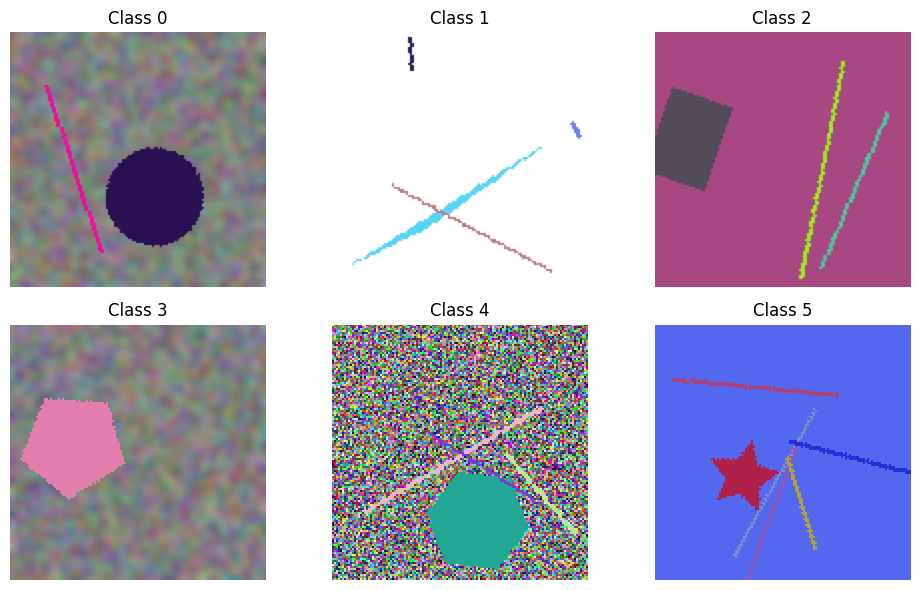

In [2]:
# Load class map
class_map = pd.read_csv(class_map_path)
print("Class Map:")
print(class_map)

# Explore training data
classes = sorted(os.listdir(train_dir)) 
print("\nClasses in training data:", classes)

# Count number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in classes}
print("\nNumber of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Visualize some sample images from each class
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i, class_name in enumerate(classes[:6]): 
    class_folder = os.path.join(train_dir, class_name)
    sample_image_path = os.path.join(class_folder, os.listdir(class_folder)[0])  # Get first image
    image = Image.open(sample_image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Class {class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation Pipeline

1. **Random Horizontal Flip**:
   - Flips the image horizontally with a probability of 50%.
   - Helps the model learn invariant features to left-right orientation.

2. **Random Rotation**:
   - Rotates the image randomly by up to ±10 degrees.
   - Makes the model robust to small angular variations in the dataset.

3. **ToTensor**:
   - Converts the image to a PyTorch tensor and normalizes pixel values to the range [0,1].

These transformations are applied dynamically during training to create unique augmented versions of each image.







In [3]:
# Augmentation Pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])


# Custom Dataset Class

**Steps in the Custom Dataset Class**:
1. **Initialization (`__init__`)**:
   - Takes the directory path of the dataset and the transformation pipeline as inputs.
   - Iterates through each class folder in the directory to collect image file paths and their corresponding labels.

2. **Length (`__len__`)**:
   - Returns the total number of images in the dataset.

3. **Get Item (`__getitem__`)**:
   - Reads an image from the stored file path.
   - Converts the image to RGB format.
   - Applies the augmentation transformations (if provided).
   - Returns the transformed image and its label.

**Dataset Loading**:
- Initializes the `CustomDataset` class with the `train_dir` path and the `transform` pipeline.
- This ensures that every time an image is loaded, the defined augmentations are applied dynamically.

In [4]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label in os.listdir(directory):
            class_folder = os.path.join(directory, label)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset with augmented transformation
dataset = CustomDataset(train_dir, transform=transform)


**We need the custom Dataset class to efficiently load, preprocess, and augment images dynamically during training, ensuring compatibility with PyTorch's DataLoader.**

# Splitting the Dataset and Creating DataLoaders

1. **Dataset Split**:
   - The dataset is split into **80% training** and **20% validation** subsets using `random_split`.
   - This ensures the model is trained on most of the data while a portion is reserved for validation to evaluate performance.

2. **DataLoaders**:
   - `train_loader`: Loads the training subset in batches of size 32 with shuffling enabled to ensure a diverse order of samples in each epoch.
   - `val_loader`: Loads the validation subset in batches of size 32 without shuffling for consistent evaluation.

3. **Output**:
   - Prints the number of samples in the training and validation subsets, confirming the split proportions.

In [5]:
# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 1280, Validation samples: 320


#  Edge Detection Layer

This cell defines a custom PyTorch layer that applies **Sobel edge detection** to input images to enhance edge features.

**How It Works**:
1. Converts the input tensor to NumPy format for OpenCV processing.
2. Handles both single-channel (grayscale) and multi-channel (RGB) images by converting them to grayscale.
3. Applies Sobel filters to compute edge features in both horizontal and vertical directions.
4. Converts the resulting edge-detected images back into tensors for PyTorch compatibility.

In [6]:
# Define the edge detection layer
class EdgeDetectionLayer(nn.Module):
    def __init__(self):
        super(EdgeDetectionLayer, self).__init__()

    def forward(self, x):
        # Convert tensor to NumPy for OpenCV processing
        x_np = x.detach().cpu().numpy()
        edges = []
        for img in x_np:
            # Handle single-channel input
            if img.shape[0] == 1:  # If grayscale (single-channel)
                gray_img = (img[0] * 255).astype(np.uint8)  # Scale to 0-255
            else:  # If multi-channel (e.g., RGB)
                img = img.transpose(1, 2, 0)  # Convert to HWC
                gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            edge_img = cv2.Sobel(gray_img, cv2.CV_64F, 1, 1, ksize=5)
            edge_img = torch.tensor(edge_img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
            edges.append(edge_img)
        return torch.stack(edges).to(x.device)


**We need the edge detection layer to enhance shape-relevant features in noisy images, making it easier for the model to focus on structural details.**

#  Enhanced Attention Module

Implements an attention mechanism to help the model focus on the most important regions and features in the feature maps.

**Components**:
1. **Channel Attention**:
   - Computes global statistics (average pooling) across spatial dimensions to identify which channels are most relevant.
   - Uses a small multi-layer perceptron (MLP) with activation (`ReLU`) and gating (`Sigmoid`) to generate channel-wise importance weights.
   - Multiplies the input feature map by these weights to enhance the most important channels.

2. **Spatial Attention**:
   - Computes spatial importance weights using a convolutional layer.
   - Highlights key spatial regions in the feature map.
   - Multiplies the input feature map by these weights to focus on important spatial areas.

**Forward Pass**:
- First applies channel attention to weight feature maps by their importance.
- Then applies spatial attention to highlight critical spatial regions.
- Returns the refined feature map for further processing.










In [7]:
# Define the enhanced attention module
class EnhancedAttentionModule(nn.Module):
    def __init__(self):
        super(EnhancedAttentionModule, self).__init__()
        # Channel Attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 64, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=1, stride=1),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        channel_weights = self.channel_attention(x)
        x = x * channel_weights
        # Spatial Attention
        spatial_weights = self.spatial_attention(x)
        x = x * spatial_weights
        return x

**to dynamically emphasize important spatial regions and feature channels, improving the model's ability to handle noisy backgrounds and focus on relevant shapes.**



# Noise-Resilient CNN Model

 A custom convolutional neural network (CNN) designed to handle noisy images by incorporating edge detection and an attention mechanism.

**Key Components**:
1. **Edge Detection Layer**:
   - Extracts edge features from input images to suppress noise and focus on structural details.

2. **Convolutional and Pooling Layers**:
   - A series of convolutional layers (`Conv2d`) extract hierarchical features from edge-detected images.
   - Batch normalization (`BatchNorm2d`) improves training stability and speeds up convergence.
   - Max pooling (`MaxPool2d`) reduces spatial dimensions while retaining important features.

3. **Enhanced Attention Mechanism**:
   - Dynamically emphasizes important spatial regions and feature channels using the `EnhancedAttentionModule`.

4. **Fully Connected Layers**:
   - Dynamically computes the flattened size after the convolutional and attention layers using a dummy input (`compute_flattened_size`).
   - Includes dropout (`Dropout`) for regularization to prevent overfitting.
   - Outputs probabilities for six classes (shapes).

**Forward Pass**:
- Applies edge detection, feature extraction, attention, and classification sequentially.

**Dynamic Initialization**:
- The fully connected layer (`fc1`) is initialized dynamically to match the feature dimensions after convolution and pooling.



In [8]:
# Define the noise-resilient CNN model with edge detection and enhanced attention
class NoiseResilientCNN(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super(NoiseResilientCNN, self).__init__()
        
        # Edge Detection Layer
        self.edge_detection = EdgeDetectionLayer()
        
        # Feature Extraction Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = activation()
        
        # Enhanced Attention Mechanism
        self.attention = EnhancedAttentionModule()
        
        # Placeholder for dynamically calculated flattened size
        self.flattened_size = None
        self.fc1 = None  # Will be initialized dynamically
        self.fc2 = nn.Linear(256, 6)  # Output layer (6 classes)
        self.dropout = nn.Dropout(0.5)

    def compute_flattened_size(self, input_shape):
        with torch.no_grad():
            sample_input = torch.zeros(1, *input_shape)
            x = self.edge_detection(sample_input)
            x = self.pool(self.activation(self.bn1(self.conv1(x))))
            x = self.pool(self.activation(self.bn2(self.conv2(x))))
            x = self.pool(self.activation(self.bn3(self.conv3(x))))
            x = self.attention(x)
            self.flattened_size = x.numel()
            self.fc1 = nn.Linear(self.flattened_size, 256)  

    def forward(self, x):
        # Apply edge detection
        x = self.edge_detection(x)
        
        # Feature extraction
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        features = self.pool(self.activation(self.bn3(self.conv3(x))))
        
        # Enhanced attention mechanism
        x = self.attention(features)
        
        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Training Function with Early Stopping

**Key Features**:
1. **Training Phase**:
   - Model is set to training mode (`model.train()`).
   - Gradients are zeroed, forward pass is performed, and the optimizer updates weights.
   - Tracks the average training loss over all batches.

2. **Validation Phase**:
   - Model is set to evaluation mode (`model.eval()`).
   - Validation loss and accuracy are computed over the validation set.

3. **Early Stopping**:
   - Compares the current validation loss to the best loss observed so far.
   - Stops training if the validation loss does not improve for `patience` consecutive epochs.

**Inputs**:
- `model`: The PyTorch model to be trained.
- `train_loader` and `val_loader`: DataLoaders for training and validation datasets.
- `criterion`: The loss function.
- `optimizer`: The optimization algorithm.
- `patience`: Number of epochs to wait before stopping when validation loss plateaus.
- `num_epochs`: Maximum number of epochs for training.

**Outputs**:
- Prints training loss, validation loss, and validation accuracy for each epoch.
- Stops early when validation loss stops improving.

**Why We Need This**:
Early stopping prevents overfitting and saves computational resources by halting training when further epochs are unlikely to improve validation performance.

In [9]:
# Define the training function with early stopping
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, patience=5, num_epochs=20):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {100 * correct / total:.2f}%")

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break


# Hyperparameter Optimization with Optuna

Optuna to perform hyperparameter optimization, aiming to minimize validation loss by searching for the best hyperparameters.

**Steps**:
1. **Objective Function**:
   - Suggests values for key hyperparameters:
     - `num_filters1` and `num_filters2`: Number of filters in the convolutional layers.
     - `learning_rate`: The learning rate for optimization.
     - `activation`: Activation function (`ReLU` or `LeakyReLU`).
     - `optimizer`: Optimization algorithm (`Adam`, `RMSprop`, or `SGD`).
   - Defines the model with the suggested hyperparameters.
   - Trains the model for a few epochs and evaluates validation loss.
   - Reports intermediate validation loss to enable trial pruning if the model is not improving.

2. **Pruning**:
   - Stops unpromising trials early to save computation time using `trial.should_prune()`.

3. **Optuna Study**:
   - Conducts multiple trials (10 in this example) to find the best combination of hyperparameters.
   - Minimizes validation loss (`direction="minimize"`).

4. **Best Hyperparameters**:
   - Retrieves the best hyperparameter combination after all trials.
   - Prints the best parameters for reference.

5. **Training the Best Model**:
   - Initializes the model with the best hyperparameters.
   - Retrains the model on the full training dataset for 20 epochs with early stopping.

**Output**:
- The optimal hyperparameters and the validation loss achieved by the best trial.
- The best model trained on the full dataset for deployment or evaluation.

In [10]:


# Optuna Objective Function with Pruning
def objective(trial):
    # Suggest hyperparameters
    num_filters1 = trial.suggest_int("num_filters1", 16, 64, step=16)
    num_filters2 = trial.suggest_int("num_filters2", 32, 128, step=16)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    
    # Map activation functions
    activation = nn.ReLU if activation_name == "ReLU" else nn.LeakyReLU

    # Define the model with the suggested hyperparameters
    model = NoiseResilientCNN(activation=activation)
    model.compute_flattened_size((1, 128, 128))
    
    # Define optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model with pruning support
    for epoch in range(1):  
        train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, patience=2, num_epochs=1)
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Report validation loss for pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# Create an Optuna study with pruning
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=5)  

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Get best hyperparameters
best_params = study.best_params

# Map the best activation function
best_activation = nn.ReLU if best_params["activation"] == "ReLU" else nn.LeakyReLU

# Initialize the best model with the best hyperparameters
best_model = NoiseResilientCNN(activation=best_activation)
best_model.compute_flattened_size((1, 128, 128))

# Define the best optimizer based on the hyperparameters
if best_params["optimizer"] == "Adam":
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"])
elif best_params["optimizer"] == "RMSprop":
    best_optimizer = optim.RMSprop(best_model.parameters(), lr=best_params["learning_rate"])
else:
    best_optimizer = optim.SGD(best_model.parameters(), lr=best_params["learning_rate"])

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Retrain the best model on the full dataset
print("Training the best model with the optimal hyperparameters...")
train_with_early_stopping(best_model, train_loader, val_loader, criterion, best_optimizer, patience=3, num_epochs=20)


[I 2025-01-12 21:04:38,648] A new study created in memory with name: no-name-d4ab8781-a3f7-4422-aed5-02489c0d7928
<ipython-input-10-c3fe2d9dfe89>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


Epoch 1/1, Train Loss: 1.7888, Val Loss: 1.7839, Val Accuracy: 20.31%


[I 2025-01-12 21:05:38,491] Trial 0 finished with value: 17.885194420814514 and parameters: {'num_filters1': 16, 'num_filters2': 80, 'learning_rate': 0.005217916426015056, 'activation': 'LeakyReLU', 'optimizer': 'SGD'}. Best is trial 0 with value: 17.885194420814514.


Epoch 1/1, Train Loss: 1.7909, Val Loss: 1.7874, Val Accuracy: 18.12%


[I 2025-01-12 21:06:41,771] Trial 1 finished with value: 17.874014258384705 and parameters: {'num_filters1': 48, 'num_filters2': 32, 'learning_rate': 0.006285427234314781, 'activation': 'ReLU', 'optimizer': 'Adam'}. Best is trial 1 with value: 17.874014258384705.


Epoch 1/1, Train Loss: 1.8172, Val Loss: 1.7975, Val Accuracy: 13.75%


[I 2025-01-12 21:07:44,396] Trial 2 finished with value: 17.965649127960205 and parameters: {'num_filters1': 32, 'num_filters2': 80, 'learning_rate': 0.00035007081184043864, 'activation': 'LeakyReLU', 'optimizer': 'Adam'}. Best is trial 1 with value: 17.874014258384705.


Epoch 1/1, Train Loss: 1.8049, Val Loss: 1.7893, Val Accuracy: 18.12%


[I 2025-01-12 21:08:46,528] Trial 3 finished with value: 17.893081426620483 and parameters: {'num_filters1': 48, 'num_filters2': 64, 'learning_rate': 0.0013130522056069571, 'activation': 'LeakyReLU', 'optimizer': 'Adam'}. Best is trial 1 with value: 17.874014258384705.


Epoch 1/1, Train Loss: 1.7849, Val Loss: 1.7782, Val Accuracy: 20.94%


[I 2025-01-12 21:09:40,976] Trial 4 finished with value: 17.809452772140503 and parameters: {'num_filters1': 64, 'num_filters2': 80, 'learning_rate': 0.00330163512883167, 'activation': 'LeakyReLU', 'optimizer': 'SGD'}. Best is trial 4 with value: 17.809452772140503.


Best hyperparameters: {'num_filters1': 64, 'num_filters2': 80, 'learning_rate': 0.00330163512883167, 'activation': 'LeakyReLU', 'optimizer': 'SGD'}
Training the best model with the optimal hyperparameters...
Epoch 1/20, Train Loss: 1.7911, Val Loss: 1.7841, Val Accuracy: 18.75%
Epoch 2/20, Train Loss: 1.7801, Val Loss: 1.7797, Val Accuracy: 18.44%
Epoch 3/20, Train Loss: 1.7804, Val Loss: 1.7845, Val Accuracy: 19.38%
Epoch 4/20, Train Loss: 1.7770, Val Loss: 1.7857, Val Accuracy: 18.75%
Epoch 5/20, Train Loss: 1.7702, Val Loss: 1.7920, Val Accuracy: 19.06%
Early stopping triggered


# Preparing the Test Dataset and Generating Predictions

1. **Define Test Dataset Class**:
   - Loads the test images and stores their file names.
   - Applies the same basic transformation (`ToTensor`) used during training.

2. **Preprocessed Test Dataset**:
   - Wraps the test dataset to apply the `EdgeDetectionLayer` dynamically.
   - Ensures that the test images are processed consistently with the training pipeline.

3. **DataLoader**:
   - Loads the preprocessed test dataset in batches of size 32 for efficient evaluation.

4. **Model Evaluation**:
   - The trained best model makes predictions for each batch of test images.
   - Predicted classes and corresponding file names are collected.

5. **Submission File**:
   - Creates a DataFrame combining file names and predicted classes.
   - Saves the predictions to a CSV file (`submission.csv`) for submission to Kaggle.

**Output**:
- The predictions are saved as a CSV file in the required format: `file_name` and `predicted_class`.


In [11]:
# Define a test dataset class with consistent preprocessing
class TestDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.transform = transform
        self.image_paths = []
        self.file_names = []
        for img_name in os.listdir(directory):
            self.image_paths.append(os.path.join(directory, img_name))
            self.file_names.append(img_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.file_names[idx]

# Use the same transformations as the training dataset
test_transform = transforms.Compose([
    transforms.ToTensor()  # Apply only the required basic transformations
])

# Apply edge detection and transformations
class PreprocessedTestDataset(Dataset):
    def __init__(self, dataset, edge_detection_layer):
        self.dataset = dataset
        self.edge_detection_layer = edge_detection_layer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, file_name = self.dataset[idx]
        image = self.edge_detection_layer(image.unsqueeze(0)).squeeze(0)  # Apply edge detection
        return image, file_name

# Initialize test dataset and apply preprocessing
raw_test_dataset = TestDataset(test, transform=test_transform)
edge_detection_layer = EdgeDetectionLayer()
test_dataset = PreprocessedTestDataset(raw_test_dataset, edge_detection_layer)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the best model on the preprocessed test dataset
print("Evaluating on the test dataset...")
predictions = []
file_names = []

best_model.eval()
with torch.no_grad():
    for images, filenames in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        file_names.extend(filenames)

# Prepare the submission file
submission = pd.DataFrame({
    "filename": file_names,
    "class_id": predictions
})

# Save the submission file
submission_file_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_file_path, index=False)
print(f"Submission file saved to {submission_file_path}")


Evaluating on the test dataset...
Submission file saved to /kaggle/working/submission.csv
